## SF Fireshed Model Prep
General framework for establishing the model parameters and inputs that are required by LANDIS-II to achieve the goals and deliverables for this sponsored research. 

### Load required libraries

In [22]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

dataDir = 'Z:/Dan K/SFFireshed/'
rasterDir = dataDir + 'raster/'
shapeDir = dataDir + 'vector/'

sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.5)

### Define temporary functions
I am working toward packaging up a set of functions that I commonly use in geospatial modeling frameworks. Those that I still need to edit or bundle up will live here temporarily.

In [23]:
def getShpGeom(shapefile):
    shp = fiona.open(shapefile)
    bds = shp.bounds
    shp.close()
    padLON = ((bds[0] - bds[2]) / 2) * 0.05
    padLAT = ((bds[1] - bds[3]) / 2) * 0.05
    ll = (bds[0] + padLON, bds[1] + padLAT)
    ur = (bds[2] - padLON, bds[3] - padLAT)
    midlat = (bds[1] + bds[3]) / 2
    midlon = (bds[0] + bds[2]) / 2
    coords = list(chain(ll, ur))
    return coords, midlat, midlon

### Define the analysis extent
and look at the extent in the context of the greater geographic area. 
The SF fireshed, as its being modeled here, is roughly 43,000 ha, and contains vegetation types
ranging from Pinon-Juniper woodlands at the lower elevations, transitioning to Ponderosa Pine 
and ultimately, up to mixtures of sub-alpine fir and Engleman Spruce at higher elevations.

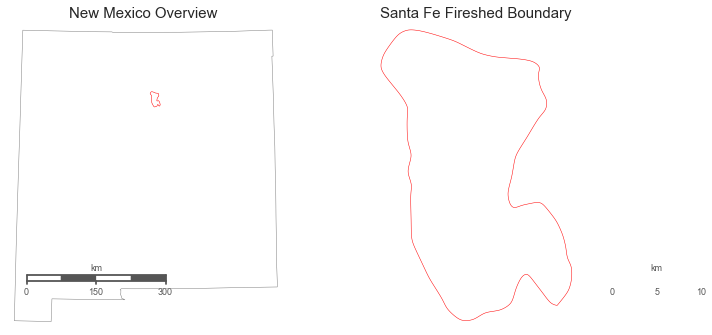

In [24]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
sns.set_style('white')
sns.despine(left = True, bottom = True)

coords, midlat, midlon = getShpGeom(shapeDir + 'NM_NAD83.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax1);

m.readshapefile(shapeDir + 'NM_NAD83', 'NewMexico',
    color='gray', zorder=5);
m.readshapefile(shapeDir + 'GSFCC_Boundary_NAD83', 'SFFireshed',
    color='red', zorder=5);

m.drawmapscale(
    coords[0]+2, coords[1]+1,
    coords[0], coords[1],
    300.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

coords, midlat, midlon = getShpGeom(shapeDir + 'GSFCC_Boundary_NAD83.shp')

m1 = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax2);

m1.readshapefile(shapeDir + 'GSFCC_Boundary_NAD83', 'GSFCC',
    color='red', zorder=5);

m1.drawmapscale(
    coords[0] + 0.35, coords[1] + 0.05,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

ax1.set_title('New Mexico Overview', fontsize = 15)
ax2.set_title('Santa Fe Fireshed Boundary', fontsize = 15)
plt.tight_layout()
plt.savefig('SFFireshed_Analysis_area.tif')